In [12]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.toy_data import *
from src.abstain import *

import sklearn
import pandas as pd

from operator import xor
from collections import defaultdict


# 2D Regret

In [13]:
# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 0,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 25,
    (0, 1): 25,
    (1, 0): 25,
    (1, 1): 25
}


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))

In [14]:
d = 2  # number of dimensions
m = 100 #number of retrainings
n_draws = 10
max_iter = 1000
noise_type = "class_conditional"
loss_type = "0-1"


In [15]:
metrics_dfs = []
instance_metrics_dfs = []
class_metrics_dfs = []

for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.49]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)

metrics_df = pd.concat(metrics_dfs)
instance_metrics_df = pd.concat(instance_metrics_dfs)
class_metrics_df = pd.concat(class_metrics_dfs)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

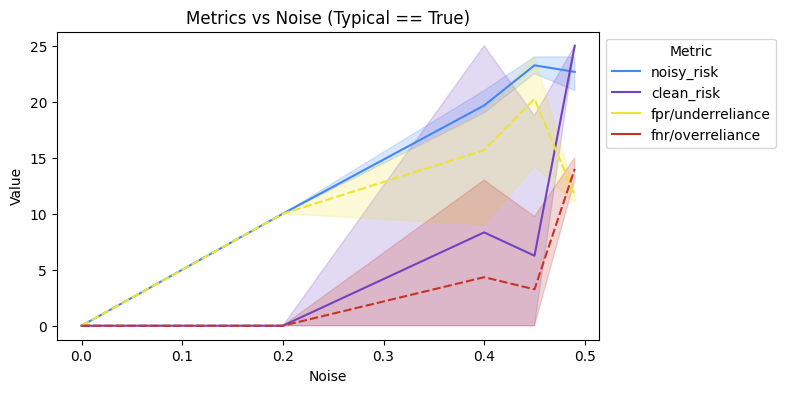

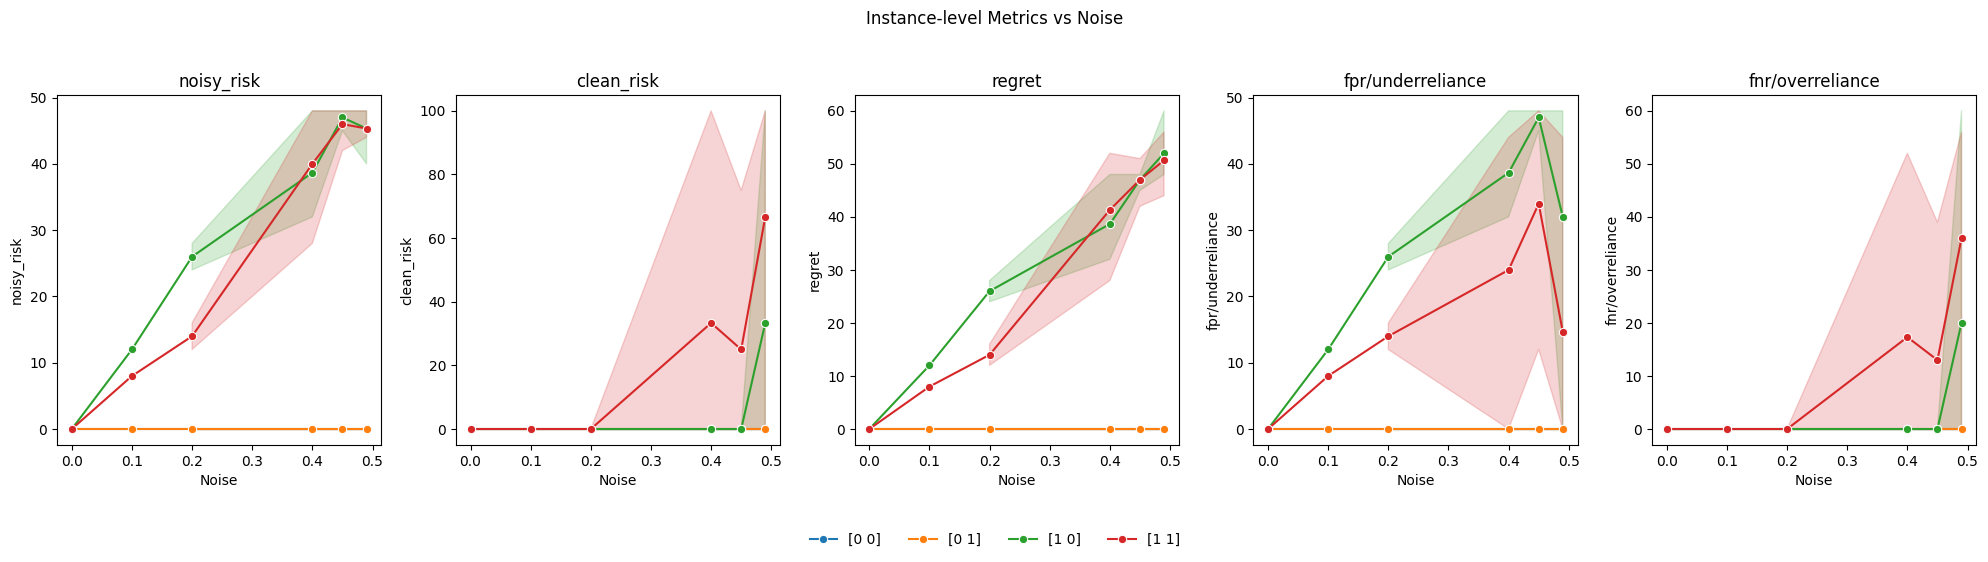

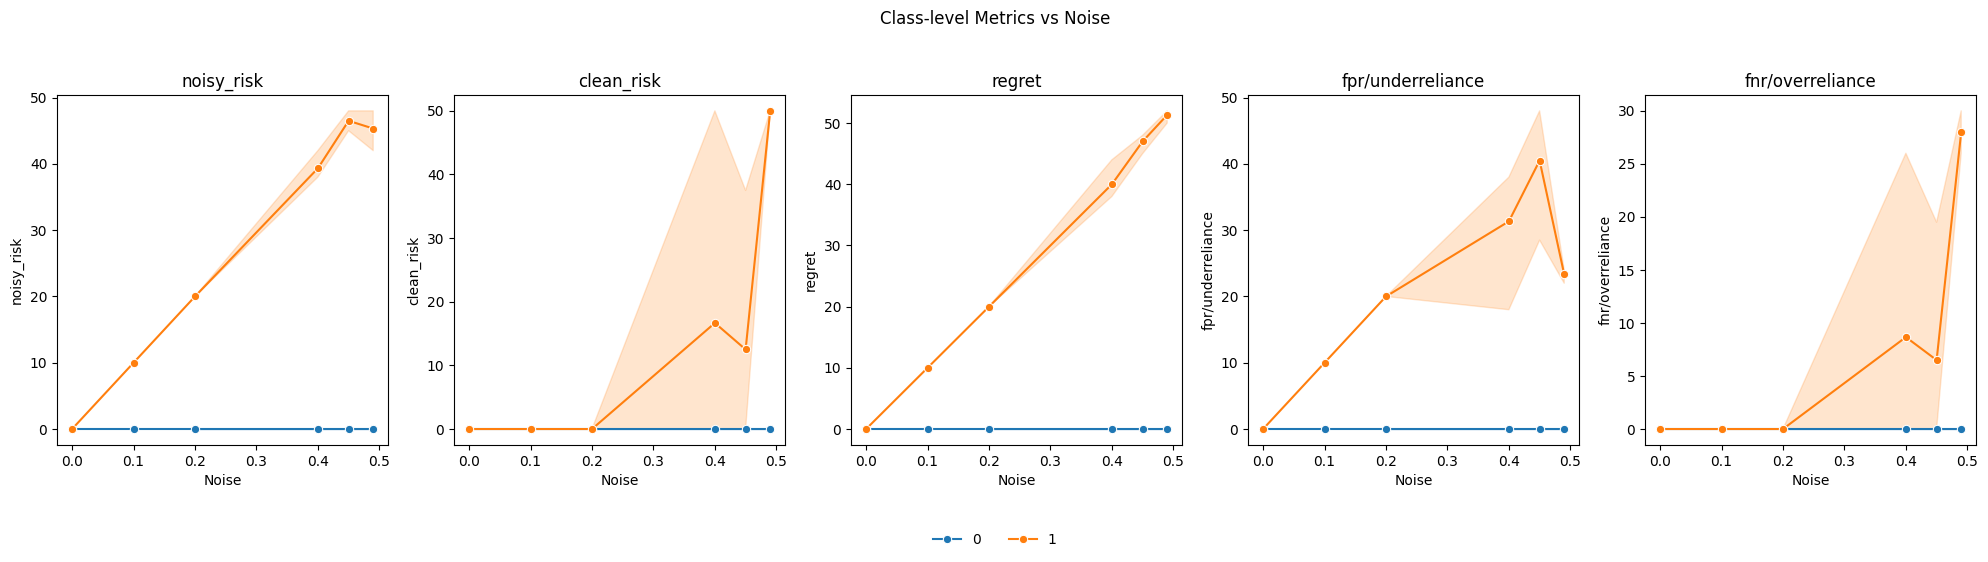

In [16]:
# Example usage
plot_regret_toy(metrics_df, instance_metrics_df, class_metrics_df)

# 2D Abstain

  0%|          | 0/100 [00:00<?, ?it/s]

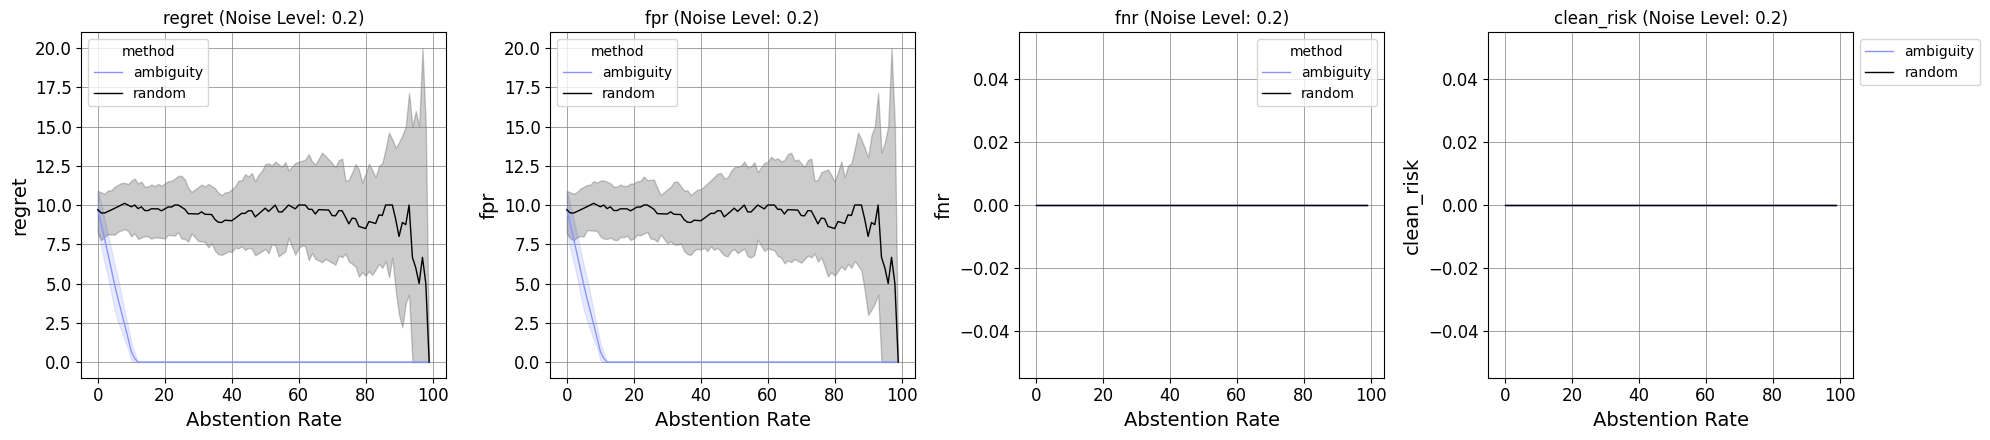

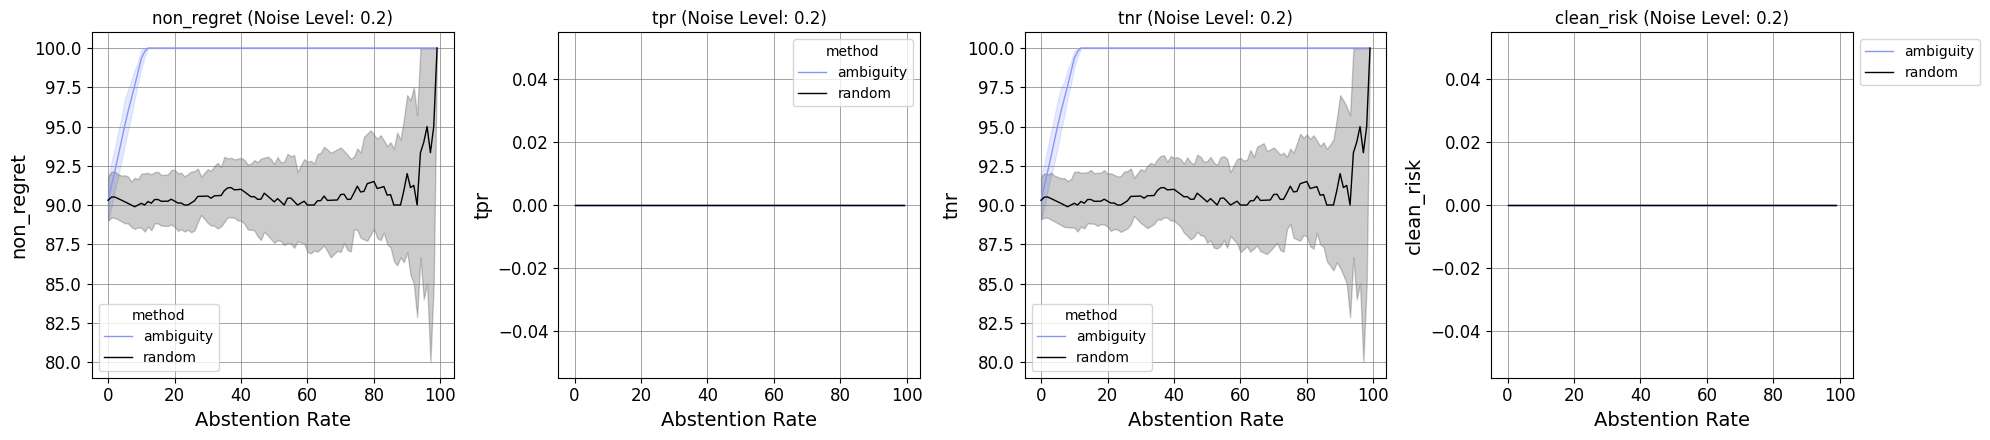

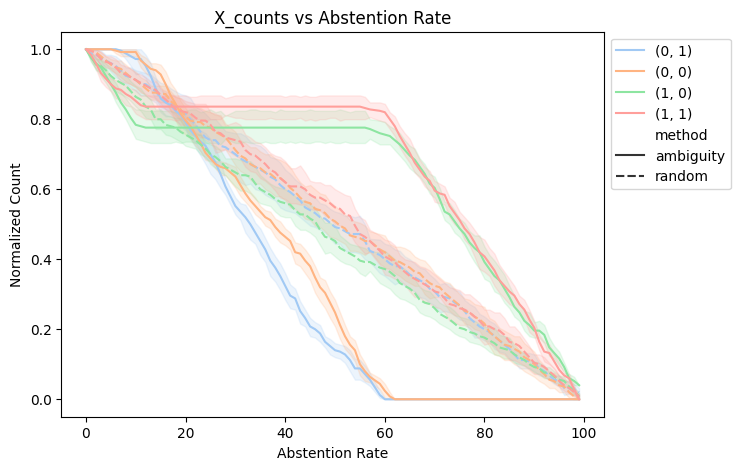

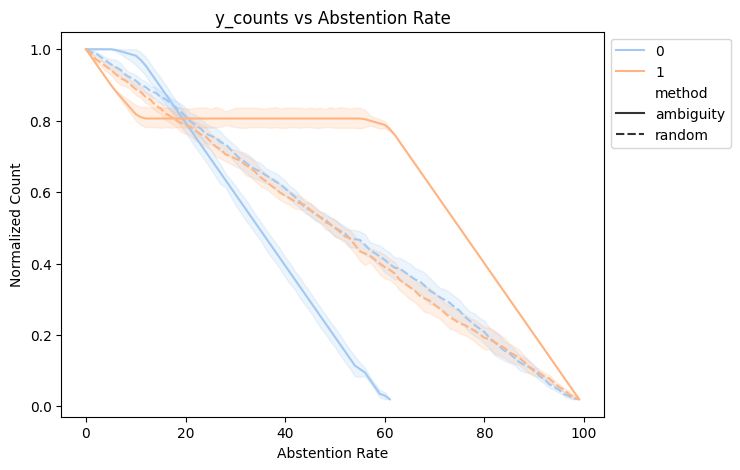

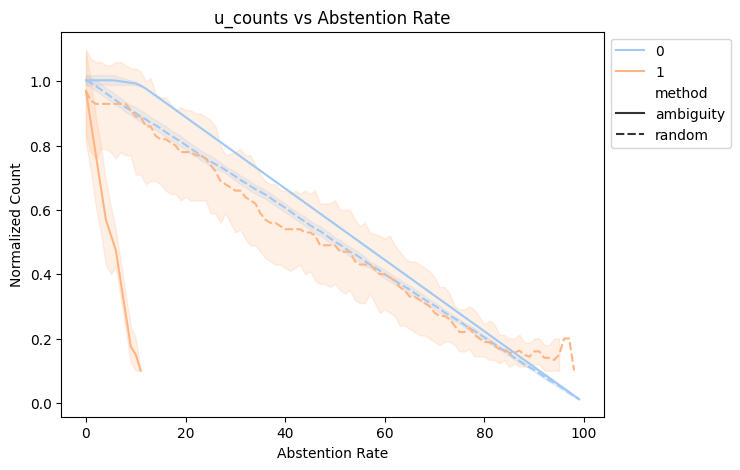

  0%|          | 0/100 [00:00<?, ?it/s]

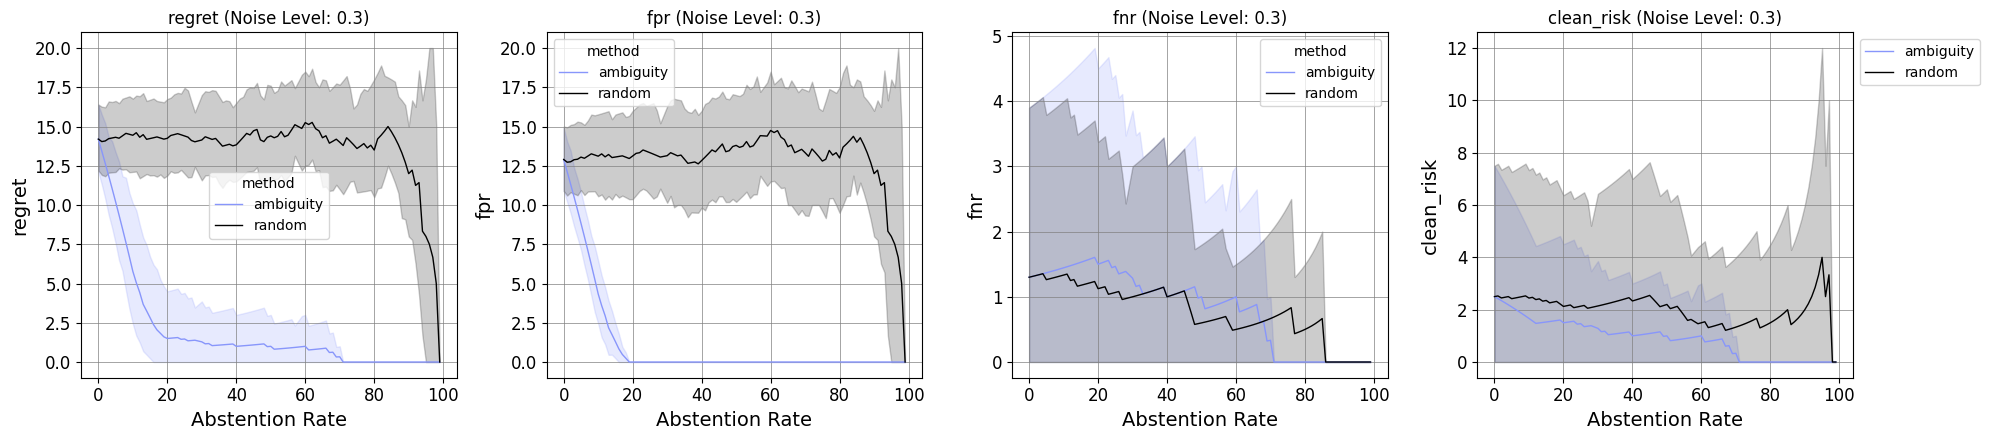

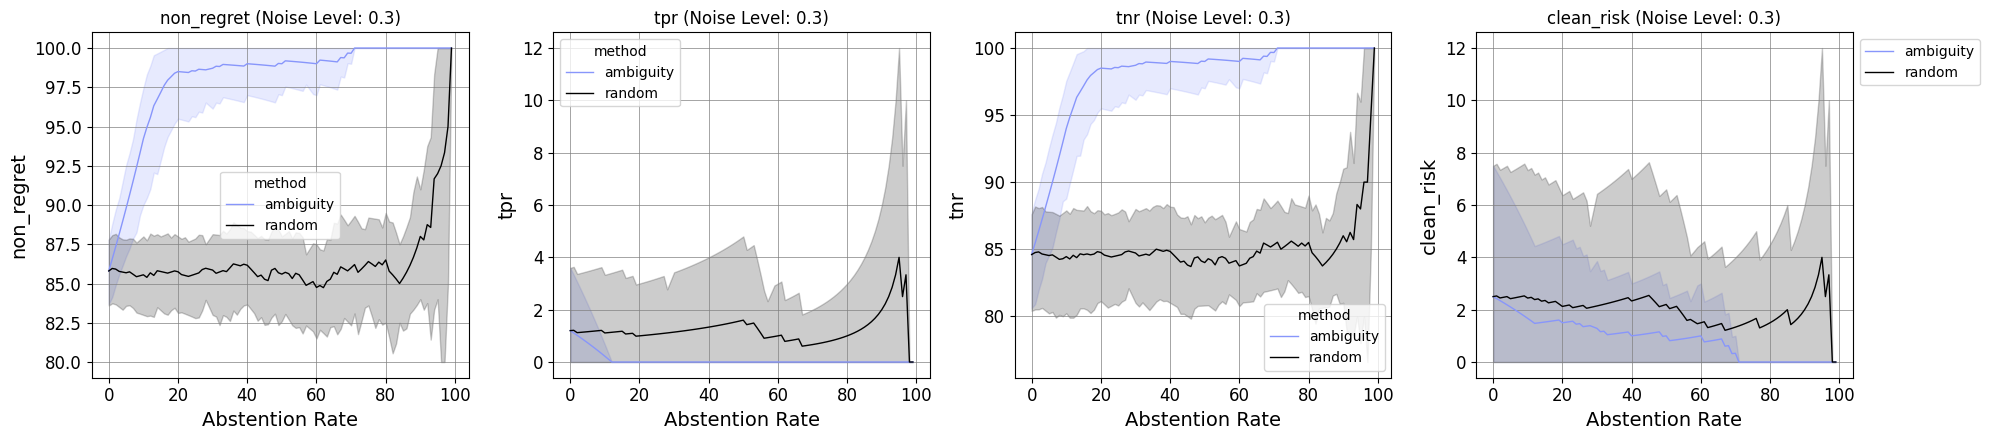

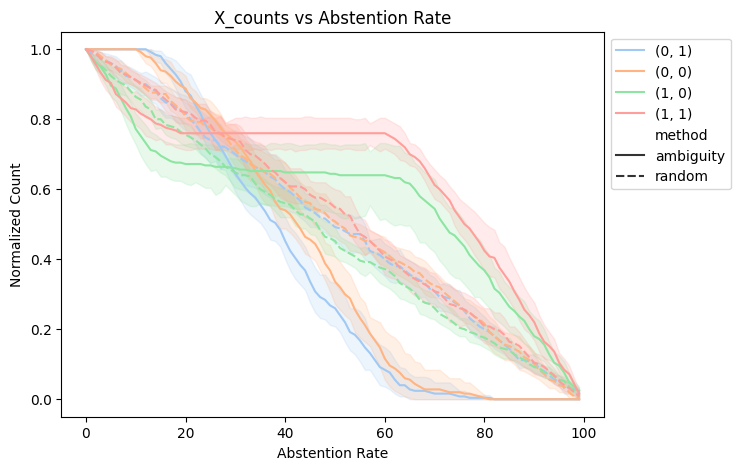

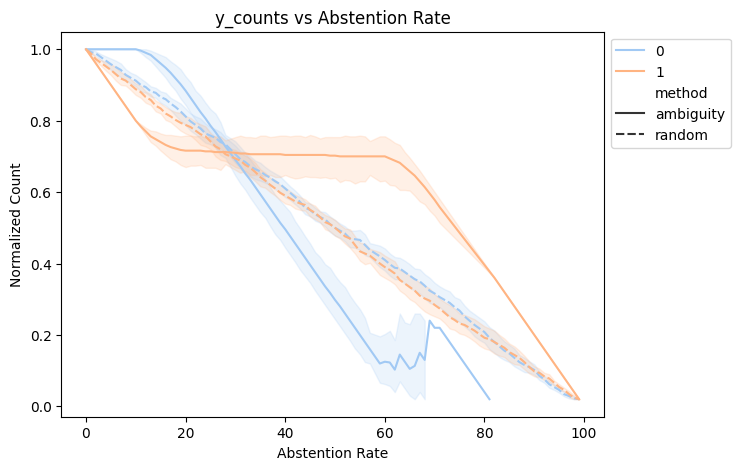

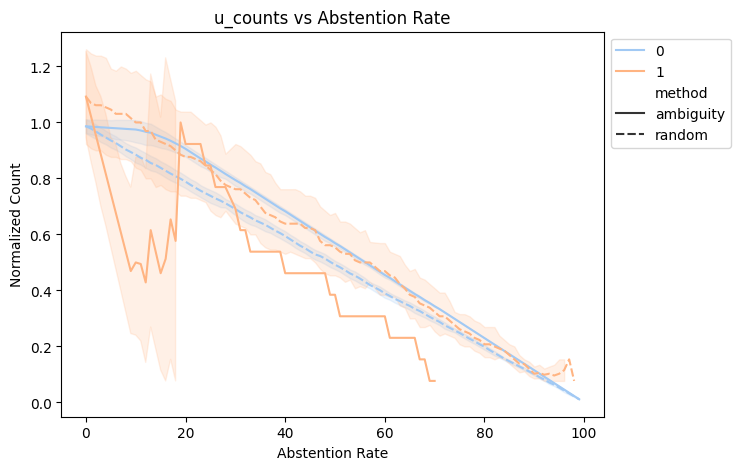

  0%|          | 0/100 [00:00<?, ?it/s]

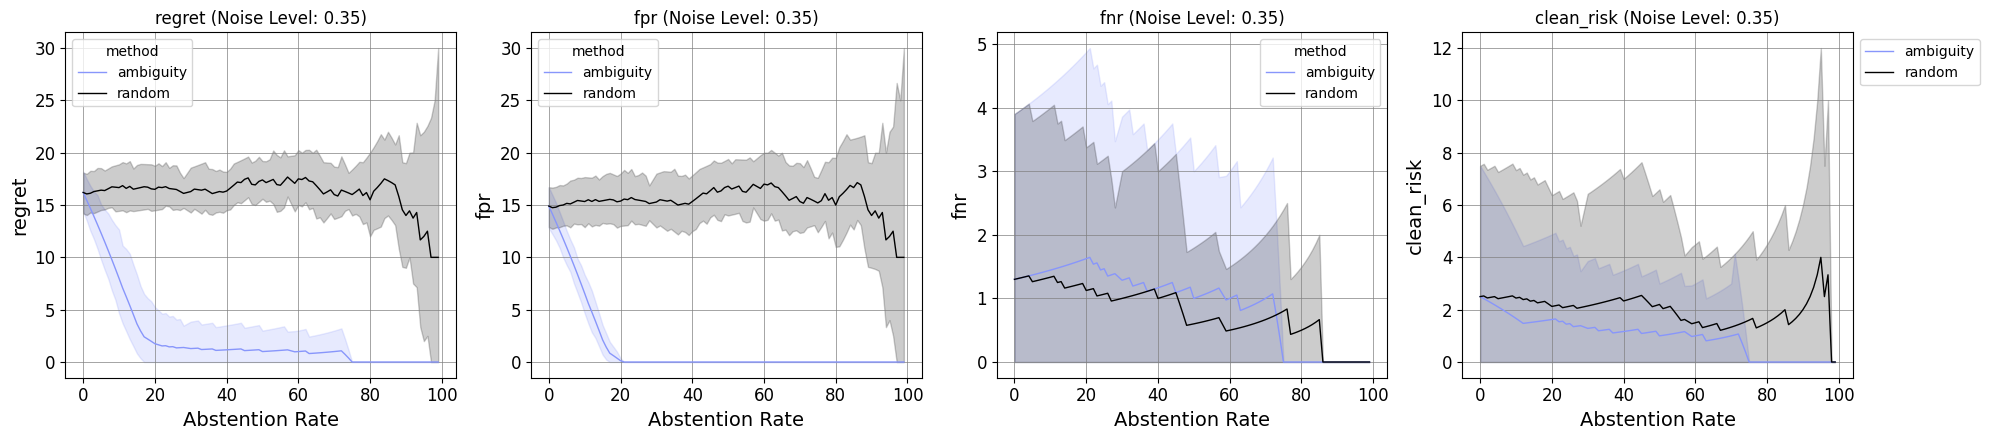

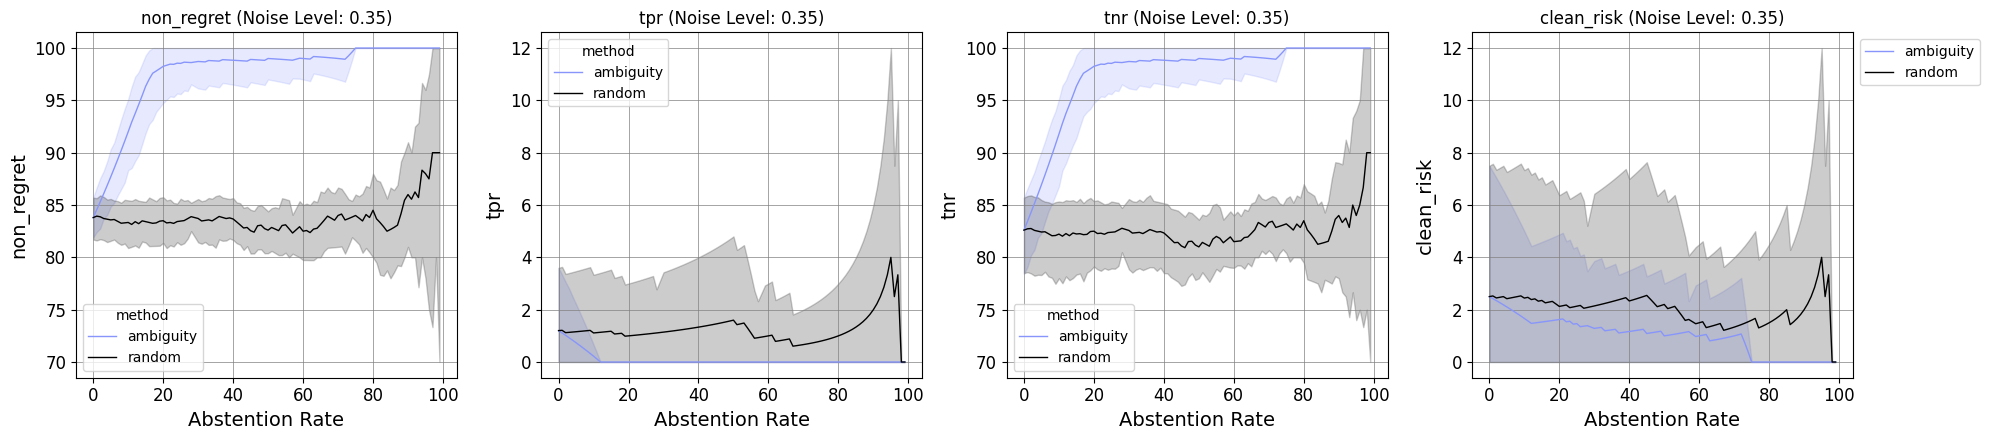

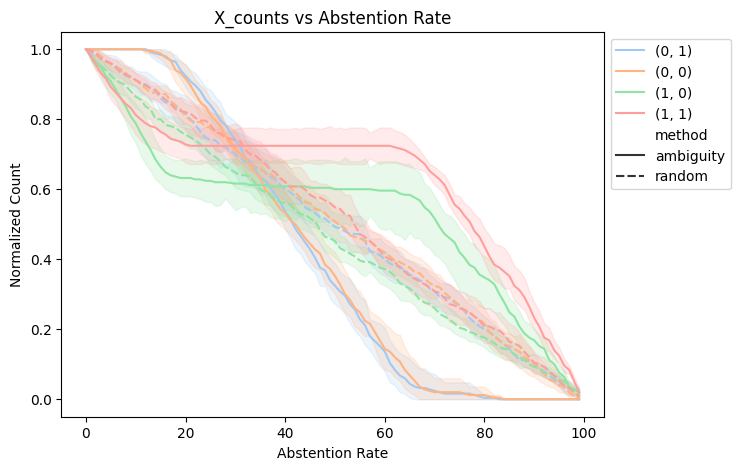

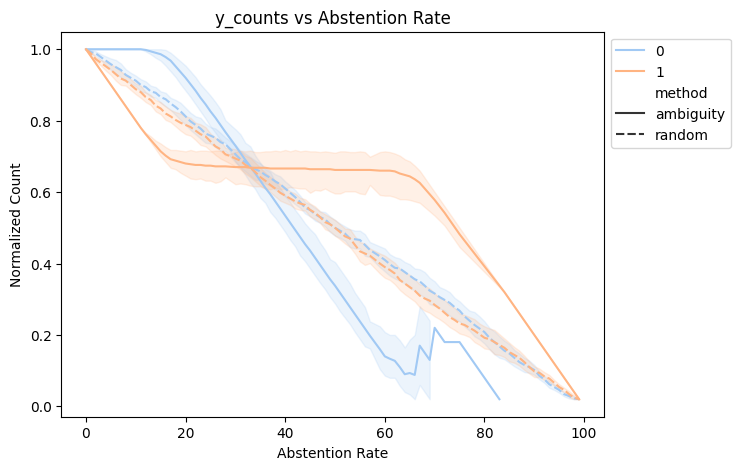

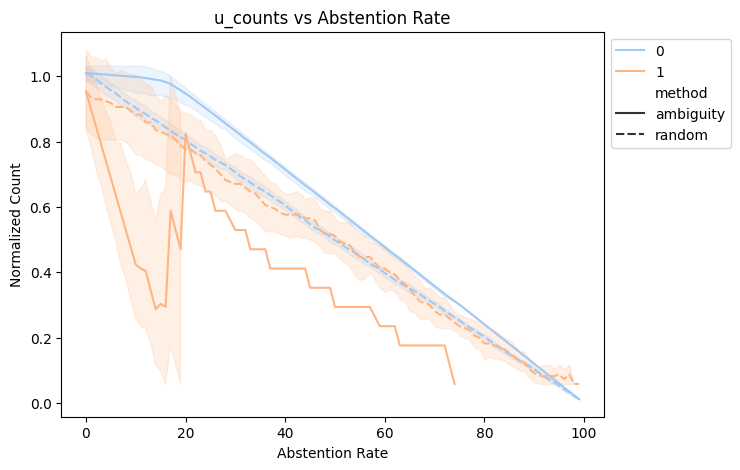

  0%|          | 0/100 [00:00<?, ?it/s]

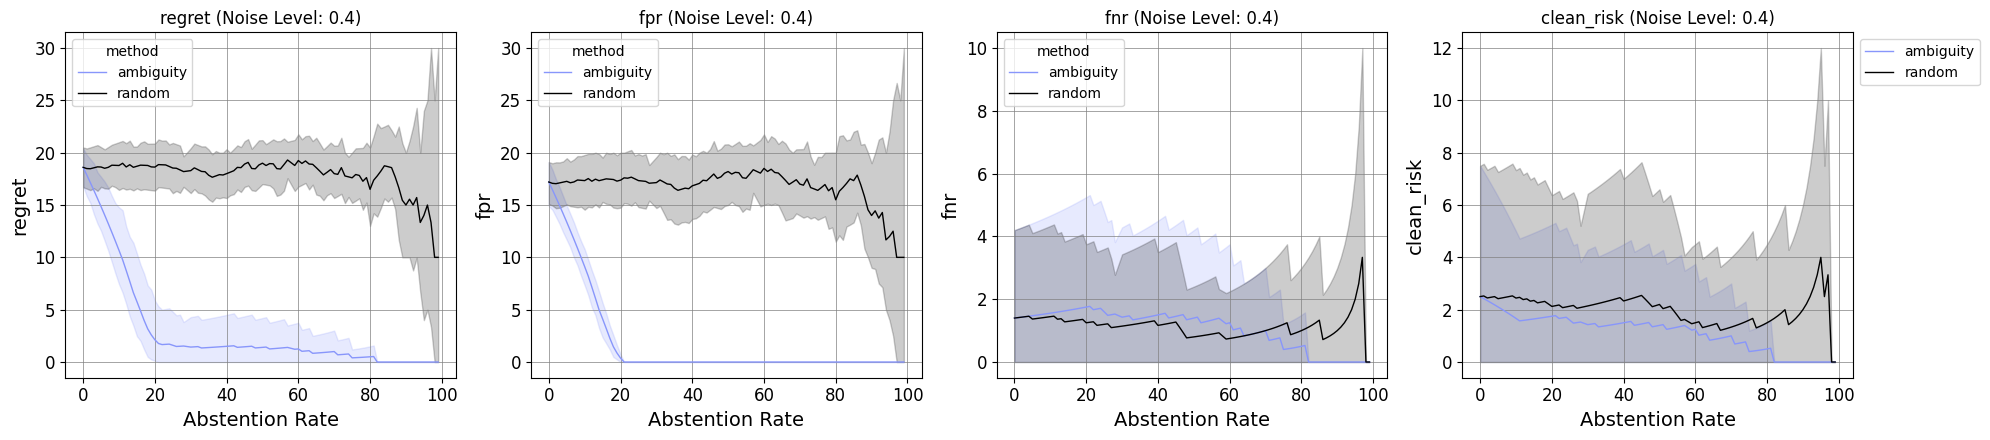

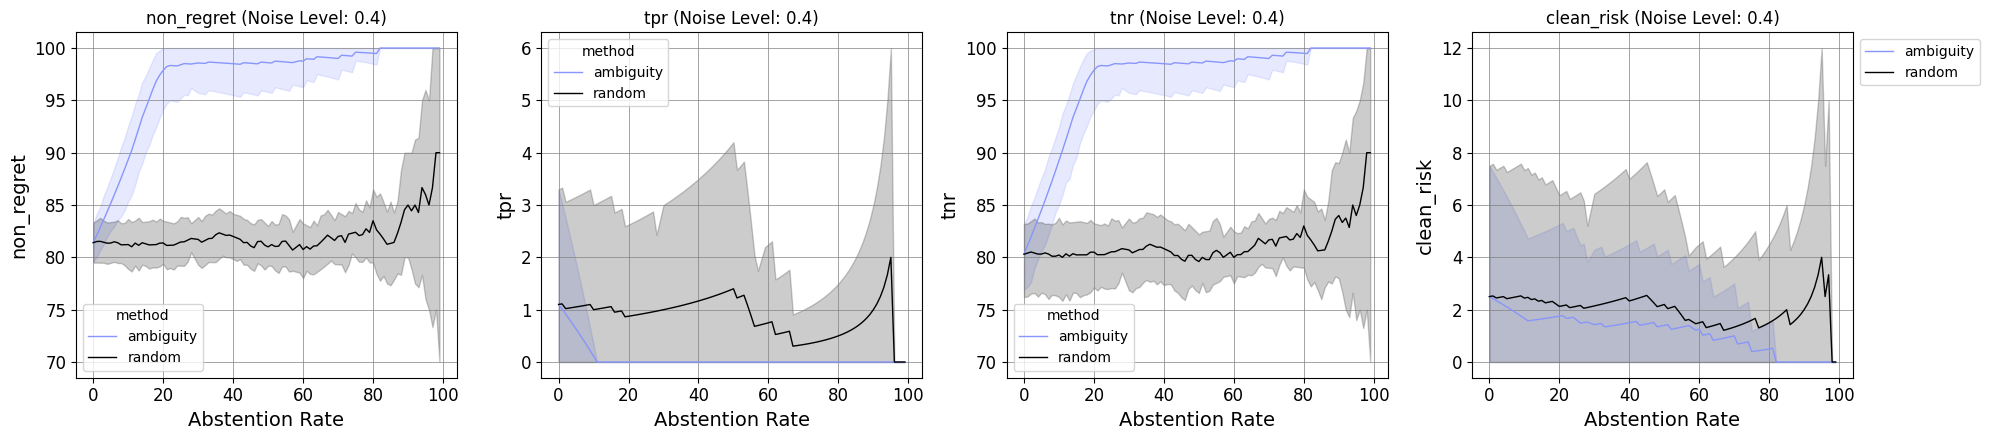

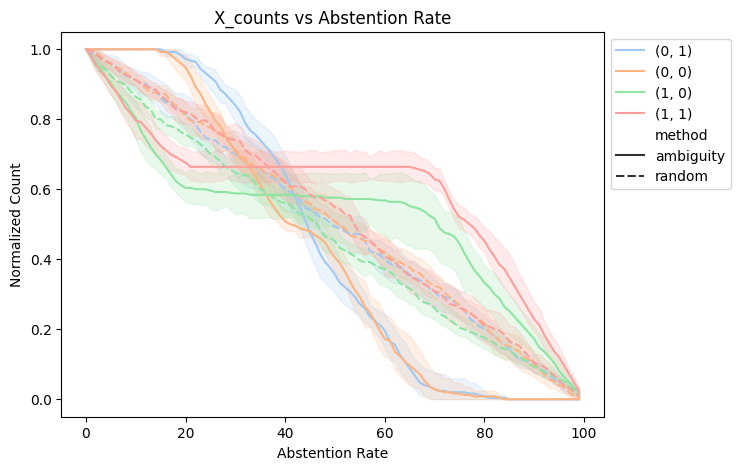

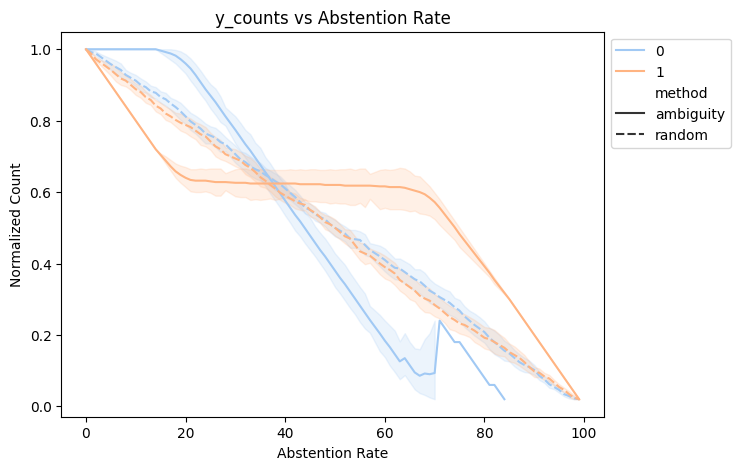

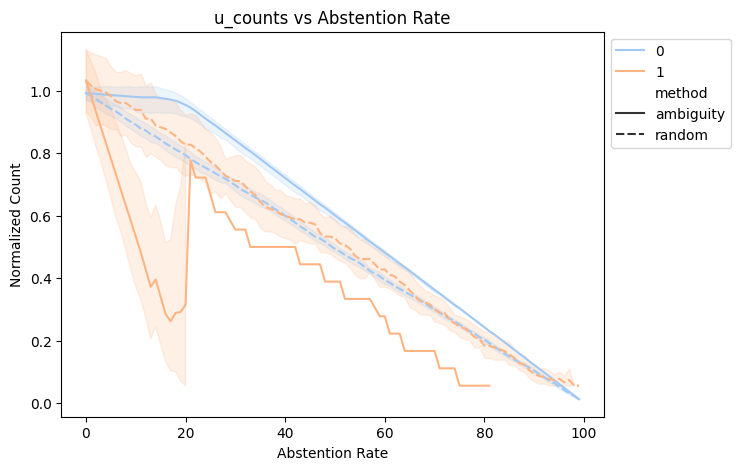

In [11]:
for noise_level in [0.2, 0.3, 0.35, 0.4]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
        data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
        plot_abstain_toy(data, noise_level)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
                data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
                plot_abstain_toy(data, noise_level)

# Ambiguity

In [ ]:
#Generate Clean Data

#Generate Noisy Draw / noisy data set

#